In [ ]:
from math import ceil

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split

## Data Exploration and Stats

In [2]:
df = pd.read_csv('coding_round_data.csv')
print(df.head(2))

   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                      0.0   
1                     0.0               2                     64.0   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0          0.2        0.2         0.0         0.0   Feb                 1   
1          0.0        0.1         0.0         0.0   Feb                 2   

   Browser  Region  TrafficType        VisitorType  Weekend  Revenue  
0        1       1            1  Returning_Visitor    False    False  
1        2       1            2  Returning_Visitor    False    False  


In [3]:
# shows that no null values exist
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
# check for imbalanced dataset
rev_true = df[df["Revenue"]==True]
print(f'Number of records where customer bought a product: {len(rev_true)}')
print(f'Total number of records: {len(df)}')

Number of records where customer bought a product: 1908
Total number of records: 12330


### Correlation between each feature and target variable

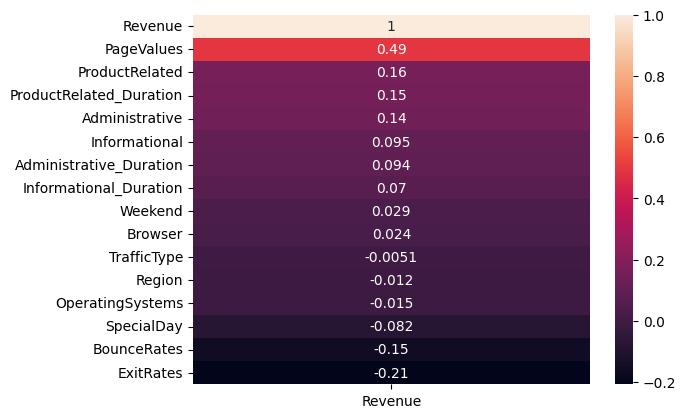

In [5]:
corr_matrix = df.corr()
# correlation between each feature and target variable
corr_df = pd.DataFrame(corr_matrix["Revenue"].sort_values(ascending=False))

# correlation using heatmap
ax = sns.heatmap(corr_df, annot=True)

### Plot Distributions

In [6]:
plt.rcParams['figure.figsize'] = [10,10]

In [7]:
continuous_var = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", 
"ProductRelated", "ProductRelated_Duration", "BounceRates", "ExitRates", "PageValues", "SpecialDay"]

# special day has limited values so also include here
categorical_var = ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
'Weekend', 'Revenue']

In [8]:
""" Inputs:
        df: dataframe
        x: list of feature names, continuous variables
    Output:
        Plots each x, to see distribution
"""
def plot_dist(df, features):

    plt.figure()
    n = len(features)
    for f, i in zip(features, range(1, n+1)):
        x = df[f]
        plt.subplot(ceil(n/2), 2, i)
        plt.plot(x)
        plt.xlabel(f)
    plt.subplots_adjust(hspace=1.2, wspace=0.5)


"""Inputs:
        df: dataframe
        features: list of column names, categorical variables
    Outputs:
        plots the count of distinct values of each column
"""
def plot_count(df, features):
    plt.figure()
    n = len(features)
    for f, i in zip(features, range(1, n+1)):
        plt.subplot(ceil(n/2), 2, i)
        df[f].value_counts().plot(kind='bar', title=f, rot=0)

    plt.subplots_adjust(hspace=1.2, wspace=0.5)
        

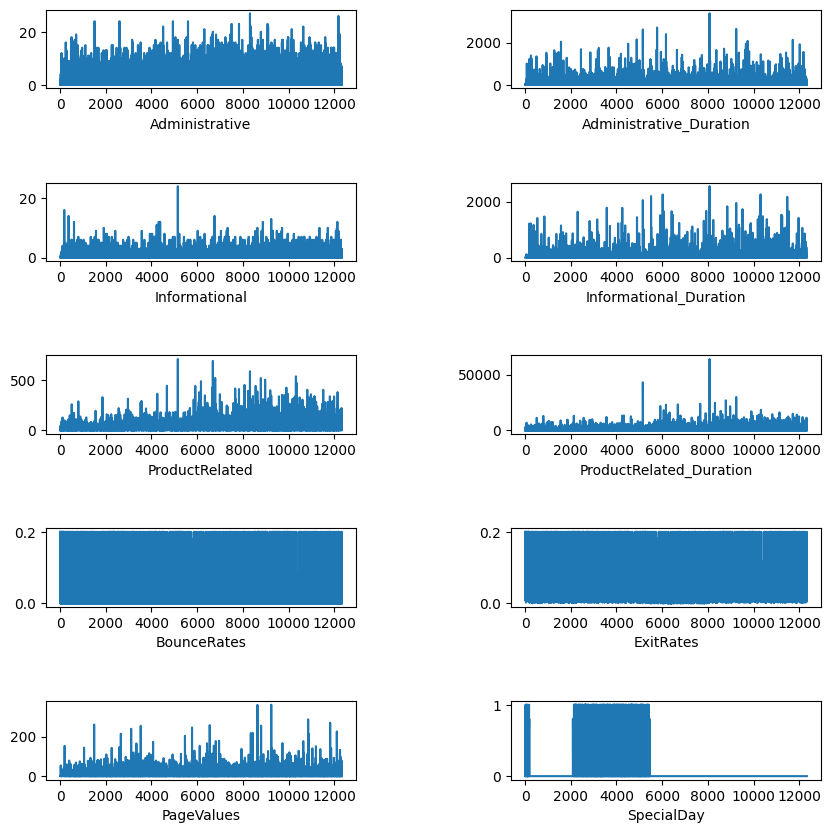

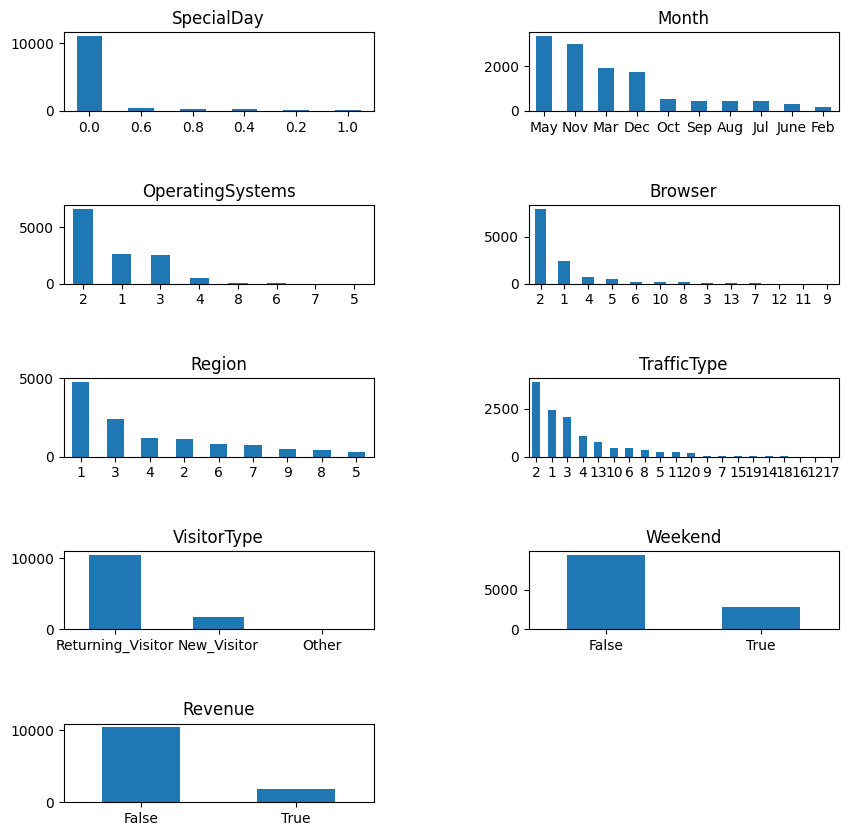

In [9]:
plot_dist(df, continuous_var)
plot_count(df, categorical_var)

### Tensorflow Extended:
- StatisticsGen component to generate statistics, schema and overall visualizations
- fix any anomalies

NOTE: tfdv treats integers as numerical features (revenue, weekend etc., as numerical) but still useful for displaying stats, validating evaluation dataset and inferring general schema

In [18]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)

train_stats = tfdv.generate_statistics_from_dataframe(train_df)
tfdv.visualize_statistics(train_stats)

In [19]:
# Infer schema from the statistics.
schema = tfdv.infer_schema(statistics=train_stats)

# Display schema
tfdv.display_schema(schema)

,Type,Presence,Valency,Domain
Feature name,,,,
'Administrative',INT,required,,-
'Administrative_Duration',FLOAT,required,,-
'Informational',INT,required,,-
'Informational_Duration',FLOAT,required,,-
'ProductRelated',INT,required,,-
'ProductRelated_Duration',FLOAT,required,,-
'BounceRates',FLOAT,required,,-
'ExitRates',FLOAT,required,,-
'PageValues',FLOAT,required,,-


,Values
Domain,
'Month',"'Aug', 'Dec', 'Feb', 'Jul', 'June', 'Mar', 'May', 'Nov', 'Oct', 'Sep'"
'VisitorType',"'New_Visitor', 'Other', 'Returning_Visitor'"


In [20]:
# Generate eval dataset statistics
eval_stats = tfdv.generate_statistics_from_dataframe(test_df)

# Compare with training
tfdv.visualize_statistics(
    lhs_statistics=eval_stats, 
    rhs_statistics=train_stats, 
    lhs_name='EVAL_DATASET', 
    rhs_name='TRAIN_DATASET'
)

In [21]:
# Check evaluation data for errors by validating the eval dataset using the original schema
anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)

# Visualize anomalies
tfdv.display_anomalies(anomalies)

## Normalization

- normalize (feature scaling) some columns in dataframe to fall in range [0, 1] using min-max normalization
- first split into train and test, normalize training data, use training data parameters to normalize test data. This way there is no information leakage and since we previously validated and compared eval dataset against training dataset, all the values will be properly normalized between [0, 1] and no NaN values either. 

In [14]:
train_norm_param = {}
feature_norm = ["Administrative", "Administrative_Duration", "Informational", "Informational_Duration", 
"ProductRelated", "ProductRelated_Duration", "PageValues"]

In [26]:
"""Inputs:
        dataf: dataframe
        features: list of column names to normalize
    Outputs:
        normalized df
"""
def normalize(dataf, features, training=True):
    df = dataf.copy()
    if training:
        for f in features:
            max = df[f].max()
            min = df[f].min()
            assert(max-min != 0)
            df[f] = (df[f] - min)/ (max - min)
            train_norm_param[f] = [min, max]

    else:
        assert(len(train_norm_param) > 0)
        for f in features:
            min, max = train_norm_param[f]
            df[f] = (df[f] - min)/ (max - min)
    return df

def validate_norm(df, features):
    for f in features:
        if not df[f].between(0, 1).all():
            print(f'{f} is not normalized acuurately')
            break
    print("Dataframe is properly normalized for the given features")

In [29]:
# first normalize training set to get min, max params
train_data = normalize(train_df, feature_norm, training=True)
validate_norm(train_data, feature_norm)

test_data = normalize(test_df, feature_norm, training=False)
validate_norm(test_data, feature_norm)

Dataframe is properly normalized for the given features
Dataframe is properly normalized for the given features
